# Introduction to pointcloud & Deepset

In [1]:
import torch#, torchvision, torchmetrics
import torch.utils.data as data
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np

In [2]:
from torchvision import datasets, transforms

In [3]:
import matplotlib.pyplot as plt

In [4]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.,), (1.0,))
        ])

dataset = datasets.MNIST('./data', train=True, download=False,transform=transform)

In [5]:
if(torch.backends.cuda.is_built()) : 
    device='cuda'
elif(torch.backends.mps.is_built()) : 
    device='mps'
else : 
    device='cpu'

In [6]:
X,y = dataset[12]

In [7]:
img_array = X[0]
torch.argwhere(img_array > 0.)[:,0]/img_array.shape[0]

tensor([0.1786, 0.1786, 0.1786, 0.1786, 0.1786, 0.1786, 0.1786, 0.1786, 0.1786,
        0.1786, 0.1786, 0.1786, 0.1786, 0.2143, 0.2143, 0.2143, 0.2143, 0.2143,
        0.2143, 0.2143, 0.2143, 0.2143, 0.2143, 0.2143, 0.2143, 0.2143, 0.2143,
        0.2143, 0.2143, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2857, 0.2857, 0.2857, 0.2857, 0.2857, 0.2857, 0.2857, 0.2857, 0.2857,
        0.2857, 0.3214, 0.3214, 0.3214, 0.3214, 0.3214, 0.3571, 0.3571, 0.3571,
        0.3571, 0.3571, 0.3571, 0.3929, 0.3929, 0.3929, 0.3929, 0.3929, 0.3929,
        0.3929, 0.4286, 0.4286, 0.4286, 0.4286, 0.4286, 0.4286, 0.4286, 0.4286,
        0.4643, 0.4643, 0.4643, 0.4643, 0.4643, 0.4643, 0.4643, 0.4643, 0.4643,
        0.4643, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5357, 0.5357, 0.5357, 0.5357, 0.5357,
        0.5357, 0.5357, 0.5357, 0.5357, 

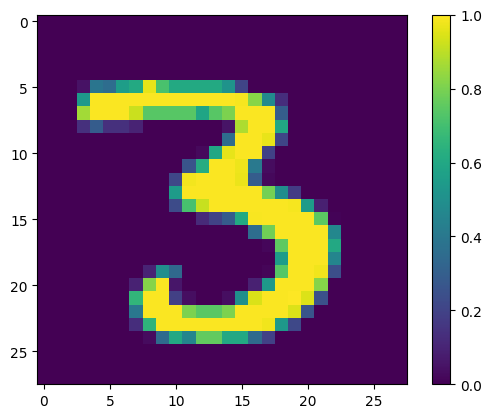

In [8]:
plt.imshow(X[0].numpy())
plt.colorbar()


In [9]:
# def transform_2d_img_to_point_cloud(data):
    
#     img, label = data
#     img_array = img[0]
#     values = img_array[img_array > 0]
#     x_coord = torch.argwhere(img_array > 0.)[:,0]/img_array.shape[0]
#     y_coord = torch.argwhere(img_array > 0.)[:,1]/img_array.shape[0]
    
#     return torch.stack( (x_coord, y_coord, values), dim=-1), label 

In [10]:
#vect = transform_2d_img_to_point_cloudT(X)

In [11]:
class MNISTPC_Dataset(data.Dataset):

    def __init__(self, dataset_path:str, train:bool = True, download:bool =False, mean:float = 0., std:float = 1.) -> None:
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        
        self.transform = transforms.Compose(
                       [
                        transforms.ToTensor(),
                        transforms.Normalize((mean,), (std,))
                       ]
                       )
        
        self.dataset = datasets.MNIST(dataset_path, train=train, download=download,
                       transform=self.transform)
        
        
        self.pc_dataset = [ self.transform_2d_img_to_point_cloud(self.dataset[idx]) for idx in range(len(self.dataset)) ]


    def transform_2d_img_to_point_cloud(self, data_i:tuple) -> dict :
    
        img, label = data_i
        img_array = img[0]
        values = img_array[img_array > 0]
        x_coord = torch.argwhere(img_array > 0.)[:,0]/img_array.shape[0]
        y_coord = torch.argwhere(img_array > 0.)[:,1]/img_array.shape[0]
        
        point_vec = torch.stack( (x_coord, y_coord, values), dim=-1)
        
        return {'point' : point_vec, 'label' : label, 'seq_length' : len(point_vec)}
        

    def __len__(self) -> int:
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return len(self.pc_dataset)
    
    def __getitem__(self, idx:int) -> dict :
        # Return the idx-th data point of the dataset
    
        return self.pc_dataset[idx]#data_point, data_label


In [12]:
pc_dataset = MNISTPC_Dataset('./data/')

In [13]:
pc_dataset[19]

{'point': tensor([[0.2500, 0.4643, 0.0706],
         [0.2500, 0.5000, 0.4118],
         [0.2500, 0.5357, 0.8902],
         [0.2500, 0.5714, 0.9922],
         [0.2500, 0.6071, 0.9922],
         [0.2500, 0.6429, 0.4784],
         [0.2857, 0.4286, 0.2235],
         [0.2857, 0.4643, 0.7804],
         [0.2857, 0.5000, 0.9922],
         [0.2857, 0.5357, 0.9882],
         [0.2857, 0.5714, 0.9882],
         [0.2857, 0.6071, 0.9882],
         [0.2857, 0.6429, 0.9882],
         [0.2857, 0.6786, 0.6235],
         [0.3214, 0.3929, 0.0784],
         [0.3214, 0.4286, 0.8275],
         [0.3214, 0.4643, 0.9882],
         [0.3214, 0.5000, 0.9098],
         [0.3214, 0.5357, 0.5961],
         [0.3214, 0.5714, 0.2863],
         [0.3214, 0.6071, 0.6549],
         [0.3214, 0.6429, 0.9882],
         [0.3214, 0.6786, 0.8431],
         [0.3214, 0.7143, 0.0235],
         [0.3571, 0.3929, 0.7725],
         [0.3571, 0.4286, 0.9882],
         [0.3571, 0.4643, 0.7137],
         [0.3571, 0.6071, 0.1451],
         [0

In [14]:
def visualize_samples(data, label, marker='o'):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
        
    plt.figure(figsize=(4,4))
    plt.scatter(data[:,0] , data[:,1], edgecolor="#333", marker=marker, label="Class " + str(label))
    
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

In [15]:
pc, label = pc_dataset[19]['point'], pc_dataset[19]['label']

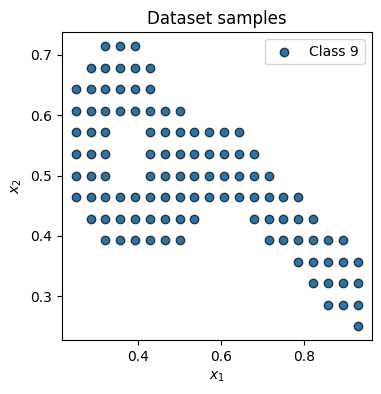

In [16]:
visualize_samples(pc, label)

In [17]:
def create_batch(data_list : list) -> tuple : 
    
    max_length = np.max([data_list[idx]['seq_length'] for idx in range(len(data_list))  ])
    
    pc_list, label_list = [], [] 
    
    for idx in range(len(data_list)) : 
        
        
        pc, label = data_list[idx]['point'], data_list[idx]['label']
        
        N, C = pc.shape[0], pc.shape[1]
        
        pc_padded = torch.zeros([1, max_length, C])
        
        pc = pc.reshape(1, N, C) # (N, C) -> (1, N, C)
        
        pc_padded[:, 0 : N, :   ] = pc[:,:,:] # 
        
        pc_list.append(pc_padded)
        label_list.append( torch.tensor([label]) )
    

    return torch.cat(pc_list, dim=0), torch.cat(label_list, dim=0)

In [18]:
type(pc_dataset)

__main__.MNISTPC_Dataset

In [19]:
pc_dataloader = data.DataLoader(dataset=pc_dataset, batch_size=5, shuffle=True, collate_fn=create_batch)

In [20]:
pc_chunk, label_chunk = next(iter(pc_dataloader))

In [21]:
pc_chunk.shape, label_chunk.shape

(torch.Size([5, 178, 3]), torch.Size([5]))

# Define the basic deepset layer

A permutation equivariant layer is defined as 
$$ 
x' = \Theta. x \equiv \gamma \mathbb{I}.x + \lambda (\mathbb{I} \mathbb{I}^T) . x~~~\lambda \,, \gamma \in \mathbb{R}
$$ 

Assuming $x = (x_1, x_2, x_3)^T$, the above equation becomes : 
$$
\begin{pmatrix}
x_1' \\
x_2' \\
x_3' 
\end{pmatrix}
= \gamma 
\begin{pmatrix}
1 && 0 && 0 \\
0 && 1 && 0 \\
0 && 0 && 1
\end{pmatrix} 
\begin{pmatrix}
x_1 \\
x_2 \\
x_3 
\end{pmatrix} + 
\lambda
\begin{pmatrix}
1 && 1 && 1 \\
1 && 1 && 1 \\
1 && 1 && 1
\end{pmatrix}  
\begin{pmatrix}
x_1 \\
x_2 \\
x_3 
\end{pmatrix} \\ \\
= 
\begin{pmatrix}
(\gamma + \lambda)x_1 + \lambda(x_2 + x_3)\\
(\gamma + \lambda)x_2 + \lambda(x_1 + x_3) \\
(\gamma + \lambda)x_3 + \lambda(x_1 + x_2) 
\end{pmatrix} \\ \\
= (\gamma + \lambda)
\begin{pmatrix}
x_1 \\
x_2 \\
x_3 
\end{pmatrix}
- \lambda
\begin{pmatrix}
x_1 - \sum x_i\\
x_2 - \sum x_i\\
x_3 - \sum x_i
\end{pmatrix}
= \Gamma .x + \Lambda.\Big(x - \alpha(x) \Big)
$$


In [22]:
class DeepSetLayer(nn.Module):
    def __init__(self, in_features:int, out_features:int,  normalization:str = '', pool:str = 'mean') -> None :
        """
        DeepSets single layer
        :param in_features: input's number of features
        :param out_features: output's number of features
        :param attention: Whether to use attention
        :param normalization: normalization method - 'fro' or 'batchnorm'
        
        """
        super(DeepSetLayer, self).__init__()

        self.Gamma = nn.Linear(in_features, out_features)
        self.Lambda = nn.Linear(in_features, out_features)

        self.normalization = normalization
        self.pool = pool
        
        if normalization == 'batchnorm':
            self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x : torch.Tensor) -> torch.Tensor :
        # x.shape = (B, N, C)
        if(self.pool == 'mean') : 
            x = self.Gamma(x) + self.Lambda(x - x.mean(dim=1, keepdim=True)) # -- the average is over the points -- #
        elif(self.pool == 'max') :
            x = self.Gamma(x) + self.Lambda(x - x.max(dim=1, keepdim=True)) # -- the max is over the points -- #

        # normalization
        if self.normalization == 'batchnorm':
            x = self.bn(x)
        

        return x

In [21]:
ds_layer = DeepSetLayer(in_features = 3, out_features = 4)

In [22]:
y = ds_layer(pc_chunk)

In [23]:
pc_chunk.shape, y.shape

(torch.Size([5, 242, 3]), torch.Size([5, 242, 4]))

## Make the full deepset model as stack of Deepset layers and non-linear activation functions

In [24]:
class DeepSet(nn.Module):
    def __init__(self, in_features:int, feats:list, n_class:int, normalization:str = '', pool:str = 'mean') ->None:
        """
        DeepSets implementation
        :param in_features: input's number of features
        :param feats: list of features for each deepsets layer
        """
        super(DeepSet, self).__init__()

        layers = []

        layers.append(DeepSetLayer(in_features = in_features, out_features = feats[0], normalization = normalization, pool = pool))
        for i in range(1, len(feats)):
            layers.append(nn.ReLU())
            layers.append(DeepSetLayer(in_features = feats[i-1], out_features = feats[i], normalization = normalization, pool = pool))

        layers.append(DeepSetLayer(in_features = feats[-1], out_features = n_class, normalization = normalization, pool = pool))
        #self.sequential = nn.Sequential(*layers)
        self.sequential = nn.ModuleList(layers)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        #return self.sequential(x)
        for i, layer in enumerate(self.sequential):
            x = layer(x)
        
        x = x.mean(dim=1) # -- average over the points -- #
        out = F.log_softmax(x, dim=-1)
        
        return out


In [25]:
model = DeepSet(in_features=3, feats=[5, 9, 12, 16, 13], n_class=10)
model = model.to(device)

In [26]:
y = model(pc_chunk.to(device))

In [27]:
y.shape, label_chunk.shape

(torch.Size([5, 10]), torch.Size([5]))

In [28]:
F.nll_loss(input=y, target=label_chunk.to(device))

tensor(2.3288, device='mps:0', grad_fn=<NllLossBackward0>)

In [29]:
torch.backends.mps.is_built()

True

In [30]:
device

'mps'

## creating the training block

In [31]:
def train(model, device, train_loader, optimizer):
    
    train_loss_ep = 0.
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss_ep += loss.item() * data.size(0)
        
    return train_loss_ep



## create the testing block

In [32]:
def test(model, device, test_loader):
    
    test_loss_ep = 0.
    
    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
         
        output = model(data)
        loss = F.nll_loss(output, target)
        
        test_loss_ep += loss.item() * data.size(0)
        
    return test_loss_ep

# Let's prepare the full dataset and dataloaders

In [33]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 5
# percentage of training set to use as validation
valid_size = 0.2
# # convert data to torch.FloatTensor
# transform = transforms.ToTensor()
# choose the training and testing datasets
train_data =  MNISTPC_Dataset('./data/', train = True, download = True)
test_data = MNISTPC_Dataset('./data/', train = False, download = True)
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)
# prepare data loaders
train_loader = data.DataLoader(dataset=train_data, batch_size = batch_size, 
                                           num_workers = num_workers, sampler = train_sampler, collate_fn=create_batch)
valid_loader = data.DataLoader(train_data, batch_size = batch_size,
                                          num_workers = num_workers,  sampler = valid_sampler, collate_fn=create_batch)
test_loader = data.DataLoader(test_data, batch_size = batch_size,
                                                     num_workers = num_workers, shuffle=False, collate_fn=create_batch)


In [34]:
model = model.to(device=device)

In [35]:
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

## Run the training loop 

In [36]:
# number of epochs to train the model
n_epochs = 20
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity
for epoch in range(n_epochs):
    # monitor losses
    
    train_loss = train(model, device, train_loader, optimizer)
    
    valid_loss = test(model, device, valid_loader)
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.268707 	Validation Loss: 2.082743
Validation loss decreased (inf --> 2.082743).  Saving model ...
Epoch: 2 	Training Loss: 2.060743 	Validation Loss: 2.064959
Validation loss decreased (2.082743 --> 2.064959).  Saving model ...
Epoch: 3 	Training Loss: 2.051775 	Validation Loss: 2.045711
Validation loss decreased (2.064959 --> 2.045711).  Saving model ...
Epoch: 4 	Training Loss: 2.026649 	Validation Loss: 1.999775
Validation loss decreased (2.045711 --> 1.999775).  Saving model ...
Epoch: 5 	Training Loss: 2.006820 	Validation Loss: 1.998050
Validation loss decreased (1.999775 --> 1.998050).  Saving model ...
Epoch: 6 	Training Loss: 1.978507 	Validation Loss: 1.959579
Validation loss decreased (1.998050 --> 1.959579).  Saving model ...
Epoch: 7 	Training Loss: 1.857825 	Validation Loss: 1.936993
Validation loss decreased (1.959579 --> 1.936993).  Saving model ...
Epoch: 8 	Training Loss: 1.643015 	Validation Loss: 1.380269
Validation loss decreased (1.93699

## Load the best saved model and use it for test performance

In [37]:
model_test = DeepSet(in_features=3, feats=[5, 9, 12, 16, 13], n_class=10)
model_test.load_state_dict(torch.load('model.pt'))
model_test.to(device)



DeepSet(
  (sequential): ModuleList(
    (0): DeepSetLayer(
      (Gamma): Linear(in_features=3, out_features=5, bias=True)
      (Lambda): Linear(in_features=3, out_features=5, bias=True)
    )
    (1): ReLU()
    (2): DeepSetLayer(
      (Gamma): Linear(in_features=5, out_features=9, bias=True)
      (Lambda): Linear(in_features=5, out_features=9, bias=True)
    )
    (3): ReLU()
    (4): DeepSetLayer(
      (Gamma): Linear(in_features=9, out_features=12, bias=True)
      (Lambda): Linear(in_features=9, out_features=12, bias=True)
    )
    (5): ReLU()
    (6): DeepSetLayer(
      (Gamma): Linear(in_features=12, out_features=16, bias=True)
      (Lambda): Linear(in_features=12, out_features=16, bias=True)
    )
    (7): ReLU()
    (8): DeepSetLayer(
      (Gamma): Linear(in_features=16, out_features=13, bias=True)
      (Lambda): Linear(in_features=16, out_features=13, bias=True)
    )
    (9): DeepSetLayer(
      (Gamma): Linear(in_features=13, out_features=10, bias=True)
      (Lam

In [38]:

def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.
    
    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:
            
            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            # preds = preds.squeeze(dim=1)
            # preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = torch.argmax(preds, dim=-1) # Binarize predictions to 0 and 10
            
            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]
            
    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [39]:
eval_model(model_test, test_loader)

Accuracy of the model: 92.27%


In [40]:
# for child in model.children():
#    print(" child : ",child)